<a href="https://colab.research.google.com/github/pranitakhade/Singapore-Resale-Flat-Prices-Predicting/blob/main/Singapore_House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [2]:
# Load the CSV files into DataFrames
df1 = pd.read_csv('/content/ResaleFlatPricesBasedonApprovalDate19901999.csv')
df2 = pd.read_csv('/content/ResaleFlatPricesBasedonApprovalDate2000Feb2012.csv')
df3 = pd.read_csv('/content/ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv')
df4 = pd.read_csv('/content/ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv')
df5 = pd.read_csv('/content/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')

In [3]:
# Concatenate the DataFrames
data = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

In [4]:
data.sample(10)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
436441,2004-05,HOUGANG,4 ROOM,421,HOUGANG AVE 10,04 TO 06,105.0,Model A,1989,227500.0,NaN
500222,2006-07,WOODLANDS,3 ROOM,202,MARSILING DR,04 TO 06,68.0,New Generation,1981,133000.0,NaN
862033,2021-12,SENGKANG,3 ROOM,164B,RIVERVALE CRES,10 TO 12,68.0,Model A,2017,350000.0,94 years 05 months
141192,1996-11,BEDOK,3 ROOM,21,CHAI CHEE RD,04 TO 06,65.0,IMPROVED,1972,160000.0,NaN
101280,1995-09,JURONG WEST,5 ROOM,555,JURONG WEST ST 42,04 TO 06,133.0,MODEL A,1985,315000.0,NaN
168838,1997-09,BUKIT BATOK,EXECUTIVE,405,BT BATOK WEST AVE 7,10 TO 12,148.0,APARTMENT,1993,580000.0,NaN
378819,2002-07,ANG MO KIO,5 ROOM,622,ANG MO KIO AVE 9,04 TO 06,121.0,Improved,1980,340000.0,NaN
272103,1999-08,TAMPINES,4 ROOM,874,TAMPINES ST 84,04 TO 06,104.0,MODEL A,1989,261000.0,NaN
266234,1999-07,PASIR RIS,EXECUTIVE,266,PASIR RIS ST 21,07 TO 09,146.0,APARTMENT,1994,450000.0,NaN
148331,1997-01,SERANGOON,EXECUTIVE,539,SERANGOON NTH AVE 4,07 TO 09,147.0,MAISONETTE,1992,638000.0,NaN


In [5]:
data.shape

(911244, 11)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911244 entries, 0 to 911243
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                911244 non-null  object 
 1   town                 911244 non-null  object 
 2   flat_type            911244 non-null  object 
 3   block                911244 non-null  object 
 4   street_name          911244 non-null  object 
 5   storey_range         911244 non-null  object 
 6   floor_area_sqm       911244 non-null  float64
 7   flat_model           911244 non-null  object 
 8   lease_commence_date  911244 non-null  int64  
 9   resale_price         911244 non-null  float64
 10  remaining_lease      202194 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 76.5+ MB


In [7]:
data.isna().sum()

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709050
dtype: int64

In [8]:
data.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,911244.000000,911244.000000,9.112440e+05
mean,95.698987,1988.101933,3.160455e+05
std,25.857337,10.482938,1.664223e+05
min,28.000000,1966.000000,5.000000e+03
25%,73.000000,1981.000000,1.905000e+05
50%,93.000000,1986.000000,2.930000e+05
75%,113.000000,1996.000000,4.100000e+05
max,307.000000,2022.000000,1.500000e+06


In [9]:
data.skew(numeric_only= True)

floor_area_sqm         0.367892
lease_commence_date    0.623207
resale_price           0.920417
dtype: float64

In [10]:
data['month'] = pd.to_datetime(data['month'])

# Extract the year and month into separate columns
data['year'] = data['month'].dt.year
data['month'] = data['month'].dt.month

In [11]:
# Calculate the remaining lease
data['remaining_lease'] = data['lease_commence_date'] + 99 - data['year']

In [12]:
data['flat_type'] = data['flat_type'].str.replace('MULTI-GENERATION', 'MULTI GENERATION')

In [13]:
data['flat_type'].value_counts()

4 ROOM              345500
3 ROOM              292060
5 ROOM              191808
EXECUTIVE            68667
2 ROOM               11372
1 ROOM                1299
MULTI GENERATION       538
Name: flat_type, dtype: int64

In [14]:
data['flat_model'] = data['flat_model'].str.lower()
data['flat_model'] = data['flat_model'].str.title()

### Visualization

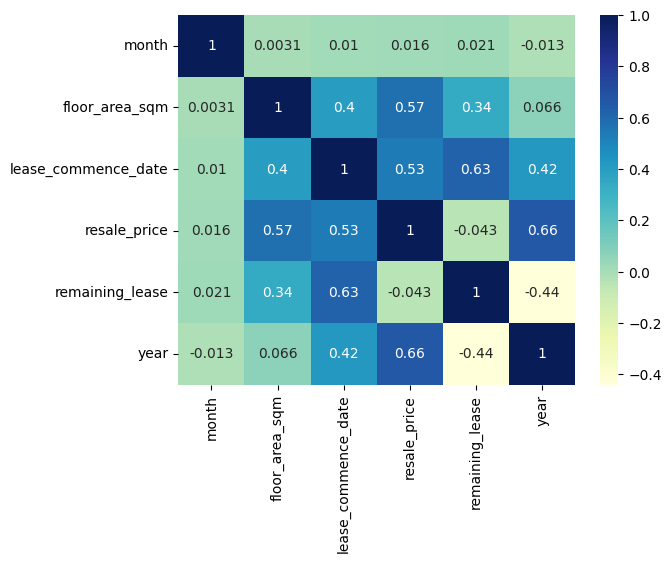

In [15]:
sns.heatmap(data.corr(numeric_only=True),cmap="YlGnBu", annot=True)
plt.show()

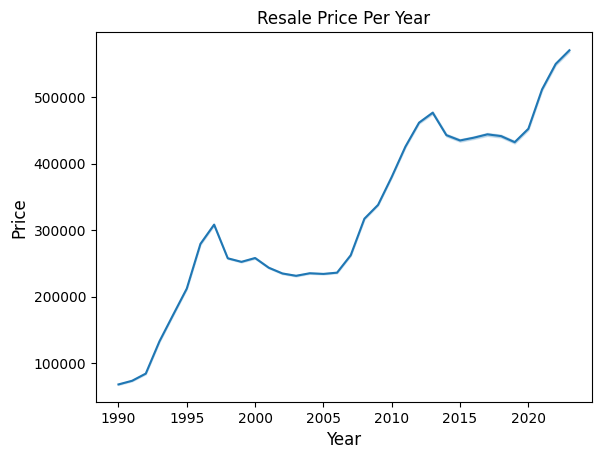

In [16]:
sns.lineplot(data = data, x ='year', y = 'resale_price')
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Price',fontsize = 12)
plt.title("Resale Price Per Year")
plt.show()

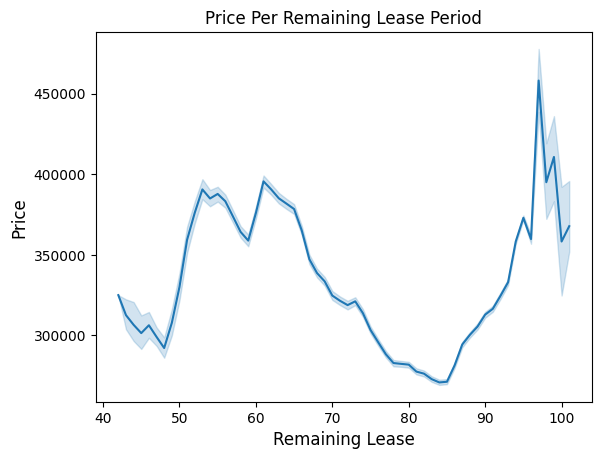

In [ ]:
sns.lineplot(data = data, x ='remaining_lease', y = 'resale_price')
plt.xlabel('Remaining Lease', fontsize = 12)
plt.ylabel('Price',fontsize = 12)
plt.title("Price Per Remaining Lease Period")
plt.show()

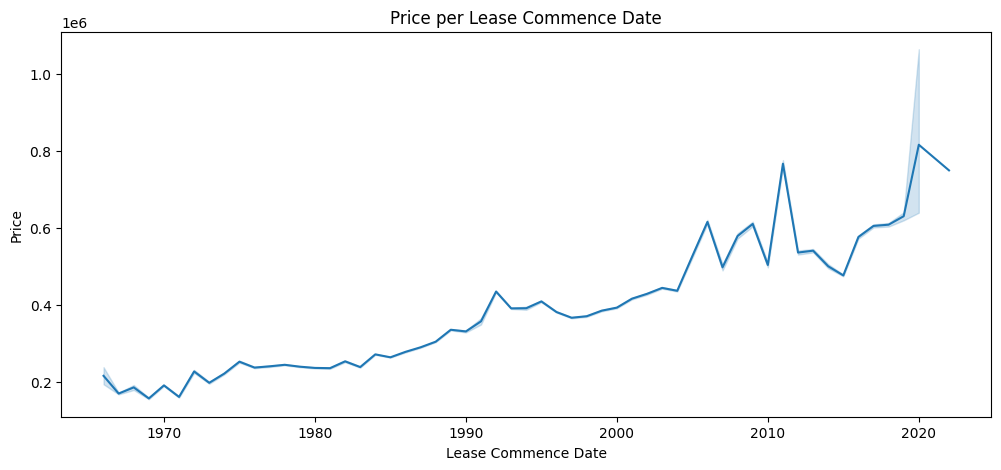

In [22]:
plt.figure(figsize=(12,5))
sns.lineplot(x='lease_commence_date', y='resale_price', data=data)
plt.xlabel('Lease Commence Date')
plt.ylabel('Price')
plt.title('Price per Lease Commence Date')
plt.show()

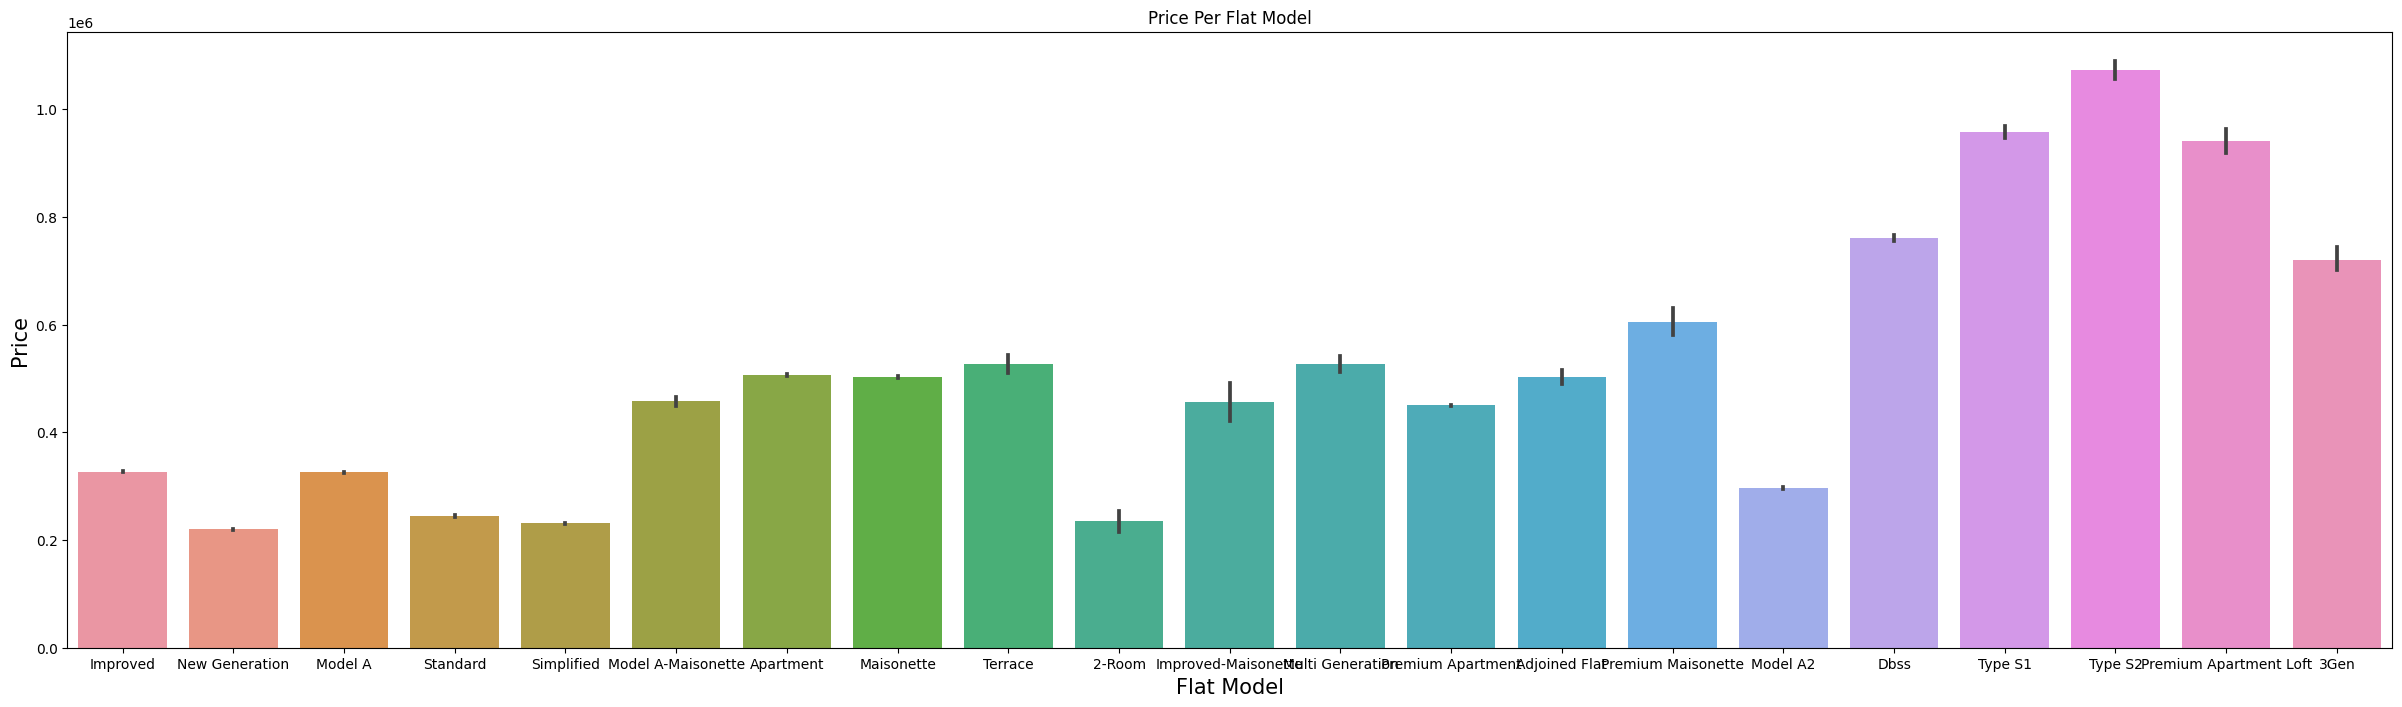

In [23]:
plt.figure(figsize=(30,8))
sns.barplot(x='flat_model',y = 'resale_price', data=data)
plt.xlabel('Flat Model', fontsize = 15)
plt.ylabel('Price',fontsize = 15)
plt.title("Price Per Flat Model")
plt.show()

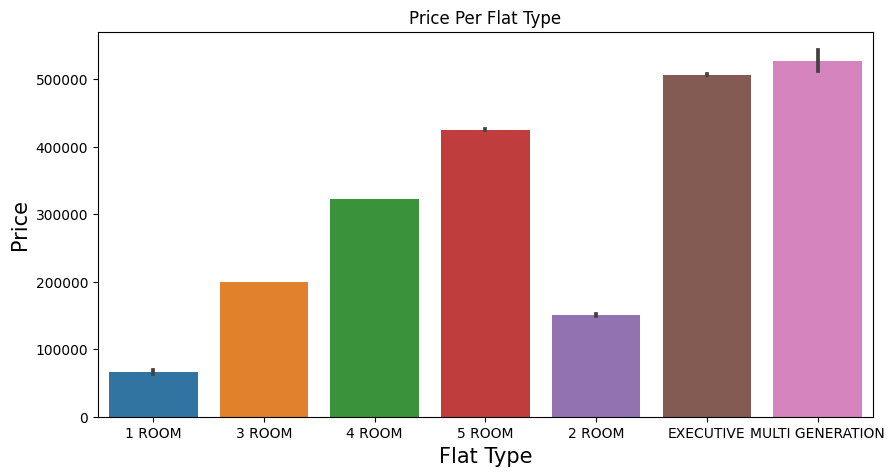

In [24]:
plt.figure(figsize=(10,5))
sns.barplot(data = data, x ='flat_type',y = 'resale_price')
plt.xlabel('Flat Type', fontsize = 15)
plt.ylabel('Price', fontsize = 15)
plt.title('Price Per Flat Type')
plt.show()

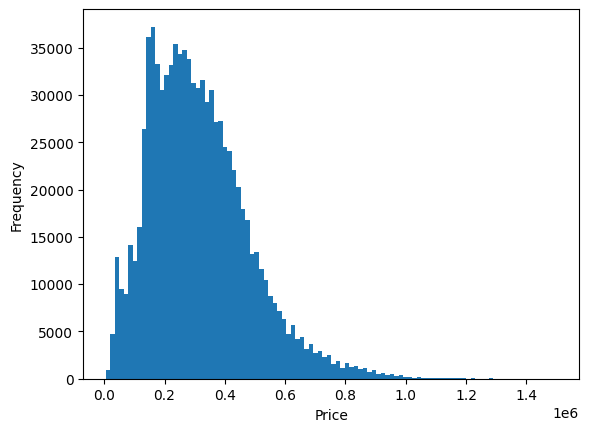

In [25]:
plt.hist(data['resale_price'], bins=100)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Calculate the average of the upper and lower bounds and create a new column 'storey_range_avg'
data['storey_range_avg'] = data['storey_range'].apply(lambda x: (int(x.split(' TO ')[0]) + int(x.split(' TO ')[1])) / 2)

# Drop the original 'storey_range' column
data.drop(columns=['storey_range'], inplace=True)

# Rename the 'storey_range_avg' column to 'storey_range'
data.rename(columns={'storey_range_avg': 'storey_range'}, inplace=True)

In [27]:
# Create a mapping from flat_type to integer values
flat_type_mapping = {
    '1 ROOM': 1,
    '2 ROOM': 2,
    '3 ROOM': 3,
    '4 ROOM': 4,
    '5 ROOM': 5,
    'EXECUTIVE': 6,
    'MULTI GENERATION' : 7
}

# Apply the mapping to the 'flat_type' column
data['flat_type_encoded'] = data['flat_type'].map(flat_type_mapping)

# You can drop the original 'flat_type' column if needed
data.drop(columns=['flat_type'], inplace=True)

# If you want to rename the new column to 'flat_type', you can do so
data.rename(columns={'flat_type_encoded': 'flat_type'}, inplace=True)

In [28]:
data.drop(['street_name','block'],axis=1, inplace = True)

### OneHotEncoding

In [29]:
data2 = pd.get_dummies(data, columns=['town', 'flat_model'])

### Train / Test Model

In [30]:
# Define features (X) and target (y)
X = data2.drop("resale_price", axis=1)
y = data2["resale_price"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Initialize the models
linear_reg_model = LinearRegression()
decision_tree_model = DecisionTreeRegressor()
random_forest_model = RandomForestRegressor()

# Train the models on the training data
linear_reg_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)

# Predict on the validation set for each model
linear_reg_pred = linear_reg_model.predict(X_val)
decision_tree_pred = decision_tree_model.predict(X_val)
random_forest_pred = random_forest_model.predict(X_val)

# Calculate regression metrics for each model
linear_reg_mae = mean_absolute_error(y_val, linear_reg_pred)
linear_reg_mse = mean_squared_error(y_val, linear_reg_pred)
linear_reg_rmse = np.sqrt(linear_reg_mse)
linear_reg_r2 = r2_score(y_val, linear_reg_pred)

decision_tree_mae = mean_absolute_error(y_val, decision_tree_pred)
decision_tree_mse = mean_squared_error(y_val, decision_tree_pred)
decision_tree_rmse = np.sqrt(decision_tree_mse)
decision_tree_r2 = r2_score(y_val, decision_tree_pred)

random_forest_mae = mean_absolute_error(y_val, random_forest_pred)
random_forest_mse = mean_squared_error(y_val, random_forest_pred)
random_forest_rmse = np.sqrt(random_forest_mse)
random_forest_r2 = r2_score(y_val, random_forest_pred)

# Display the results for all three models
print("Linear Regression Results:")
print(f"Mean Absolute Error: {linear_reg_mae}")
print(f"Mean Squared Error: {linear_reg_mse}")
print(f"Root Mean Squared Error: {linear_reg_rmse}")
print(f"R2 Score: {linear_reg_r2}")
print()

print("Decision Tree Results:")
print(f"Mean Absolute Error: {decision_tree_mae}")
print(f"Mean Squared Error: {decision_tree_mse}")
print(f"Root Mean Squared Error: {decision_tree_rmse}")
print(f"R2 Score: {decision_tree_r2}")
print()

print("Random Forest Results:")
print(f"Mean Absolute Error: {random_forest_mae}")
print(f"Mean Squared Error: {random_forest_mse}")
print(f"Root Mean Squared Error: {random_forest_rmse}")
print(f"R2 Score: {random_forest_r2}")


Linear Regression Results:
Mean Absolute Error: 52345.27588315986
Mean Squared Error: 4647226704.017754
Root Mean Squared Error: 68170.57065932303
R2 Score: 0.8329862979902278

Decision Tree Results:
Mean Absolute Error: 20942.533688349435
Mean Squared Error: 1015385396.4275185
Root Mean Squared Error: 31865.11252808498
R2 Score: 0.9635087150197758

Random Forest Results:
Mean Absolute Error: 16567.0376473169
Mean Squared Error: 604497124.1275105
Root Mean Squared Error: 24586.523221625106
R2 Score: 0.9782753652909784


### Training Model

In [28]:
# Create and train the Random Forest model using your training data
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [29]:
import pickle
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(random_forest_model, file)

In [ ]:
# Define a function to take user input
def get_user_input():
    user_input = {}

    user_input['month'] = int(input("Enter the month: "))
    user_input['floor_area_sqm'] = float(input("Enter the floor area in square meters: "))
    user_input['lease_commence_date'] = int(input("Enter the lease commencement year: "))
    user_input['remaining_lease'] = None
    user_input['year'] = int(input("Enter the year: "))
    user_input['remaining_lease'] = user_input['lease_commence_date'] + 99 - user_input['year']

    # Calculate remaining lease based on user input
    #user_input['remaining_lease'] = user_input['lease_commence_date'] + 99 - user_input['year']

    user_input['storey_range'] = float(input("Enter the storey range: "))
    user_input['flat_type'] = int(input("Enter the flat type (e.g., 1, 2, 3, etc.): "))

    town = input("Enter the town (e.g., 'BEDOK', 'TAMPINES', etc.): ")
    flat_model = input("Enter the flat model (e.g., 'Improved', 'New Generation', etc.): ")

    # Set all other 'town' columns to 0
    all_town_columns = [
        'town_ANG MO KIO', 'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
        'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA', 'town_CHOA CHU KANG',
        'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG', 'town_JURONG EAST', 'town_JURONG WEST',
        'town_KALLANG/WHAMPOA', 'town_LIM CHU KANG', 'town_MARINE PARADE', 'town_PASIR RIS',
        'town_PUNGGOL', 'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
        'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN'
    ]

    for town_column in all_town_columns:
        if town_column != f'town_{town}':
            user_input[town_column] = 0
        else:
            user_input[f'town_{town}'] = 1

    # Set all other 'flat_model' columns to 0
    all_flat_model_columns = [
        'flat_model_2-Room', 'flat_model_3Gen', 'flat_model_Adjoined Flat', 'flat_model_Apartment',
        'flat_model_Dbss', 'flat_model_Improved', 'flat_model_Improved-Maisonette',
        'flat_model_Maisonette', 'flat_model_Model A', 'flat_model_Model A-Maisonette',
        'flat_model_Model A2', 'flat_model_Multi Generation', 'flat_model_New Generation',
        'flat_model_Premium Apartment', 'flat_model_Premium Apartment Loft',
        'flat_model_Premium Maisonette', 'flat_model_Simplified', 'flat_model_Standard',
        'flat_model_Terrace', 'flat_model_Type S1', 'flat_model_Type S2'
    ]

    for flat_model_column in all_flat_model_columns:
        if flat_model_column != f'flat_model_{flat_model}':
            user_input[flat_model_column] = 0
        else:
            user_input[f'flat_model_{flat_model}'] = 1

    return user_input

In [ ]:
# Get user input
user_input_data = get_user_input()

# Create a DataFrame from the user input
user_input_df = pd.DataFrame([user_input_data])

# Use the model to make predictions
predicted_prices = random_forest_model.predict(user_input_df)

# Print the predicted resale price
print("Predicted Resale Price:", predicted_prices[0])

# Streamlit

In [8]:
%%writefile app.py

import pickle
import pandas as pd
import numpy as np
import streamlit as st

def load_model(model_file):
    with open(model_file, 'rb') as file:
        loaded_model = pickle.load(file)
    return loaded_model

def convert_storey_range(storey_range):
    return (int(storey_range.split(' TO ')[0]) + int(storey_range.split(' TO ')[1])) / 2

flat_type_mapping = {'1 ROOM': 1,'2 ROOM': 2,'3 ROOM': 3,'4 ROOM': 4,'5 ROOM': 5,'EXECUTIVE': 6,'MULTI GENERATION': 7}

month_mapping = {
  'January': 1,'February': 2,'March': 3,'April': 4,'May': 5,'June': 6,'July': 7,'August': 8,'September': 9,'October': 10,'November': 11,'December': 12
}

storey = ['01 TO 03', '01 TO 05', '04 TO 06', '06 TO 10', '07 TO 09',
          '10 TO 12', '11 TO 15', '13 TO 15', '16 TO 18', '16 TO 20',
          '19 TO 21', '21 TO 25', '22 TO 24', '25 TO 27', '26 TO 30',
          '28 TO 30', '31 TO 33', '31 TO 35', '34 TO 36', '36 TO 40',
          '37 TO 39', '40 TO 42', '43 TO 45', '46 TO 48', '49 TO 51']


all_towns = ['ANG MO KIO','BEDOK','BISHAN','BUKIT BATOK','BUKIT MERAH',
            'BUKIT PANJANG','BUKIT TIMAH','CENTRAL AREA','CHOA CHU KANG',
            'CLEMENTI','GEYLANG','HOUGANG','JURONG EAST','JURONG WEST',
            'KALLANG/WHAMPOA','LIM CHU KANG','MARINE PARADE','PASIR RIS','PUNGGOL',
            'QUEENSTOWN','SEMBAWANG','SENGKANG','SERANGOON','TAMPINES',
            'TOA PAYOH','WOODLANDS','YISHUN']


all_flat_model = ['2-Room','3Gen','Adjoined Flat','Apartment','Dbss',
                  'Improved','Improved-Maisonette','Maisonette','Model A','Model A-Maisonette',
                  'Model A2','Multi Generation','New Generation','Premium Apartment','Premium Apartment Loft',
                  'Premium Maisonette','Simplified','Standard','Terrace','Type S1','Type S2']

def get_user_input():
    user_input = {}

    st.write("#### Enter the Details:")

    # Display "Month" as a dropdown with month names
    month = st.selectbox("Month", list(month_mapping.keys()))
    user_input['month'] = month_mapping[month]
    year = st.number_input("Year (YYYY)", min_value=1990, max_value=2023)

    user_input['floor_area_sqm'] = st.number_input("Floor Area (sqm)")
    user_input['lease_commence_date'] = st.number_input("Lease Commencement Year (YYYY)", min_value=1966, max_value=2023)

    user_input['remaining_lease'] = None
    user_input['year'] = year

    user_input['remaining_lease'] = user_input['lease_commence_date'] + 99 - user_input['year']

    # Display "storey_range" as a select box with input as "01 TO 03"
    storey_range = st.selectbox("Storey Range", storey)

    # Convert storey range to the average of the range
    user_input['storey_range'] = convert_storey_range(storey_range)

    # Display "flat_type" as a dropdown with user-friendly names
    flat_type = st.selectbox("Flat Type", list(flat_type_mapping.keys()))
    user_input['flat_type'] = flat_type_mapping[flat_type]

    town = st.selectbox("Town", all_towns)
    all_town_columns = []
    for i in all_towns:
        all_town_columns.append(f'town_{i}')

    for town_column in all_town_columns:
        if town_column != f'town_{town}':
            user_input[town_column] = 0
        else:
            user_input[f'town_{town}'] = 1


    flat_model = st.selectbox("Flat Model", all_flat_model)
    all_flat_model_columns = []
    for i in all_flat_model:
        all_flat_model_columns.append(f'flat_model_{i}')

    for flat_model_column in all_flat_model_columns:
        if flat_model_column != f'flat_model_{flat_model}':
            user_input[flat_model_column] = 0
        else:
            user_input[f'flat_model_{flat_model}'] = 1

    return user_input

def main():
    st.set_page_config(page_title="Singapore Resale Flat Price Prediction - Made by: Pranit Akhade",layout="wide",initial_sidebar_state="auto")

    st.title("Singapore Resale Flat Price Prediction")

    user_input_data = get_user_input()

    if st.button("Predict"):
        user_input_df = pd.DataFrame([user_input_data])
        loaded_model = load_model('random_forest_model.pkl')
        predicted_price = loaded_model.predict(user_input_df)
        st.write(f"### Predicted Resale Price: S$ {predicted_price[0]:.2f}")

if __name__ == "__main__":
    main()

Overwriting app.py


In [2]:
!wget -q -O - ipv4.icanhazip.com

35.184.201.144


In [9]:
!streamlit run /content/app.py & npx localtunnel -p 8501

[..................] / rollbackFailedOptional: verb npm-session ed360609846db4e


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.184.201.144:8501

npx: installed 22 in 4.018s
your url is: https://fifty-colts-battle.loca.lt
  Stopping...
^C


____________